In [2]:
%load_ext autoreload
%autoreload 1
%aimport src.utils

import os
import wget

from matplotlib import pyplot as plt
import numpy as np
import scipy.io as sio
import torch
import torch.nn.functional as F
from tqdm import tqdm

from src import utils  # our utils

In [3]:
# Downloads and loads data to current directory.
# TODO replace wget with request https://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3, put in utils
img_path = "IMAGES.mat"
if not os.path.exists(img_path):
    data_url = "http://rctn.org/bruno/data/IMAGES.mat"
    wget.download(data_url, out=img_path) # will download 20M to current directory
imgs = sio.loadmat(img_path)["IMAGES"] # 512x512x10 (10 512x512 binary, whitened images)

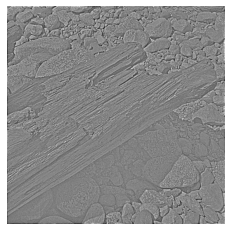

In [4]:
# Visualize images.
plt.axis('off')
plt.imshow(imgs[:,:,0], cmap="gray")

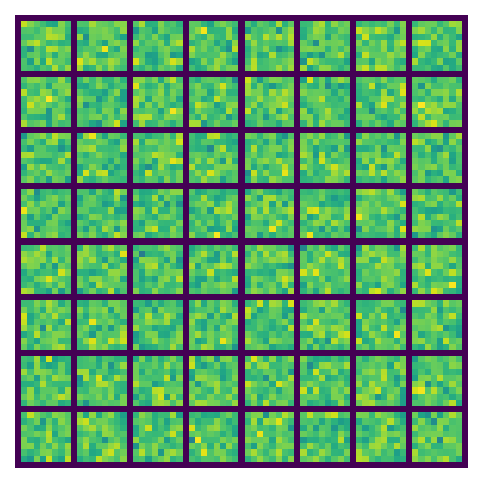

In [19]:
# Init variables
num_bases = 64
basis_size = 64
rng = np.random.default_rng(seed=0)

# Set these parameters
epochs = 3000
num_infer_iters = 1000
batch_size = 100
lambd_div_sigma = 0.14  # Figure 4 description.

a_lr = 1e-3
eta = 1e-3
patch_size = 8 # 8x8 image # 16x16 in paper

# Nonlinear function and its derivative.
S = lambda x: torch.log(1 + x**2)
S_prime = lambda x: (2*x)/(x**2 + 1)

# S = lambda x: -torch.exp(-torch.square(x))
# S_prime = lambda x: 2*x*torch.exp(-torch.square(x))

# For display purposes.
def loss_fn(I, Ihat, a, sigma):
    mse = F.mse_loss(Ihat, I).data  # Equation 3.
    sparseness = torch.sum(S(a/sigma))  # Equation 4.
    return mse, sparseness # Equation 2.

# Initialize dict and visualize.
phi = torch.randn(basis_size, num_bases)
phi = F.normalize(phi, dim=0)
phi_init = phi.clone()

phi_grid = utils.visualize_bases(phi_init)
utils.display(phi_grid, bar=False)


In [10]:
# pre compute batches (slowest part)
# patches = torch.zeros((epochs, batch_size, basis_size))
# for i in range(epochs):
#     patches[i, :,: ] = torch.Tensor(utils.extract_patches(imgs, patch_size, batch_size, rng))  # (batch_size, basis_size)
# torch.save(patches, "patches_5k")

# load batches
patches = torch.load("patches_5k")


In [12]:
losses = []
for i in tqdm(range(epochs)):
    I = patches[i, :, :] 
    sigma = torch.sqrt(torch.var(I))  # Fig. 4 description
    lambd = lambd_div_sigma * sigma
    
    # This inner for loop uses Euler's method to learn coefficients a.
    a = torch.zeros(batch_size, num_bases)
    for _ in range(num_infer_iters):
        b = torch.mm(I, phi)  # (batch_size, num_bases)
        C = torch.mm(phi.T, phi) - torch.eye(num_bases)  # (num_bases, num_bases)

        # Obtain gradient based on Equation 5
        da = b - torch.mm(C, a.T).T - ((lambd_div_sigma) * S_prime(a/sigma))  # (batch_size, num_bases)
        a += a_lr * (da/batch_size)  # (batch_size, num_bases)

    # Update basis gradients.
    Ihat = torch.mm(phi, a.T).T  # (batch_size, basis_size)
    dphi = torch.mm((I - Ihat).T, a)  # Equation 6, (basis_size, num_bases)
    phi += eta * dphi

    # Normalize each basis to unit length.
    phi = F.normalize(phi, dim=0)

    # Calculate loss for display purposes.
    mse, sparseness = loss_fn(I, Ihat, a, sigma)
    total = (mse + lambd * sparseness) / batch_size
    if i % 250 == 0:
        print("total: {}, mse: {}, sparse: {}".format(total, mse, sparseness))
    losses.append(total)

phi_final = torch.clone(phi)
print("final total: {}, mse: {}, sparse: {}".format(total, mse, sparseness))

  0%|          | 1/3000 [00:00<19:11,  2.60it/s]

total: 0.01110311783850193, mse: 1.0219980478286743, sparse: 0.6179800629615784


  8%|▊         | 251/3000 [01:12<13:27,  3.40it/s]

total: 0.013116102665662766, mse: 1.1200897693634033, sparse: 1.2686927318572998


 17%|█▋        | 501/3000 [02:26<11:14,  3.70it/s]

total: 0.010892385616898537, mse: 0.8348435759544373, sparse: 1.927887201309204


 25%|██▌       | 751/3000 [03:39<10:47,  3.47it/s]

total: 0.011181720532476902, mse: 0.8306843638420105, sparse: 2.1770832538604736


 33%|███▎      | 1001/3000 [04:51<09:43,  3.43it/s]

total: 0.012827307917177677, mse: 0.9477787613868713, sparse: 2.3655717372894287


 42%|████▏     | 1251/3000 [06:04<08:28,  3.44it/s]

total: 0.012183941900730133, mse: 0.8877220749855042, sparse: 2.410574436187744


 50%|█████     | 1501/3000 [07:18<07:09,  3.49it/s]

total: 0.010893246158957481, mse: 0.8026197552680969, sparse: 2.2055912017822266


 58%|█████▊    | 1751/3000 [08:31<05:20,  3.90it/s]

total: 0.011401056312024593, mse: 0.829244077205658, sparse: 2.3473806381225586


 67%|██████▋   | 2001/3000 [09:50<05:03,  3.29it/s]

total: 0.01251126267015934, mse: 0.9037846326828003, sparse: 2.505687952041626


 75%|███████▌  | 2251/3000 [11:03<03:37,  3.44it/s]

total: 0.010630491189658642, mse: 0.7646504044532776, sparse: 2.3465352058410645


 83%|████████▎ | 2501/3000 [12:18<02:36,  3.18it/s]

total: 0.010643072426319122, mse: 0.7544779777526855, sparse: 2.4484469890594482


 92%|█████████▏| 2751/3000 [13:30<01:17,  3.23it/s]

total: 0.01312757097184658, mse: 0.9895870685577393, sparse: 2.238914966583252


100%|██████████| 3000/3000 [14:44<00:00,  3.39it/s]

final total: 0.011034076102077961, mse: 0.833686351776123, sparse: 2.0414633750915527


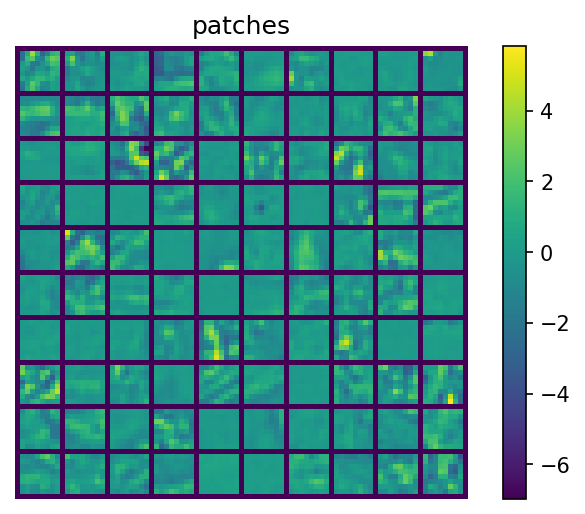

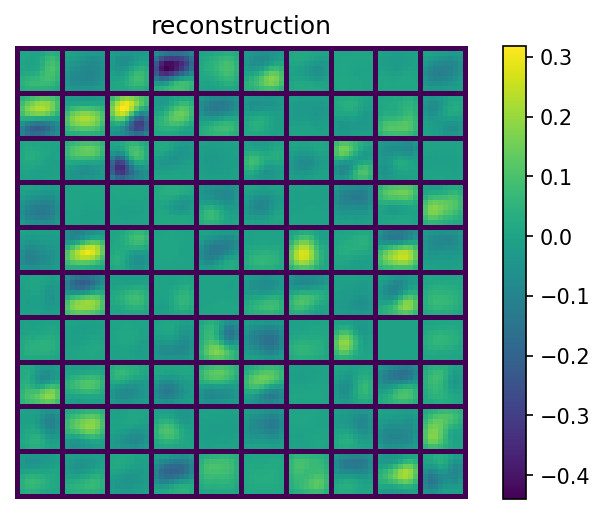

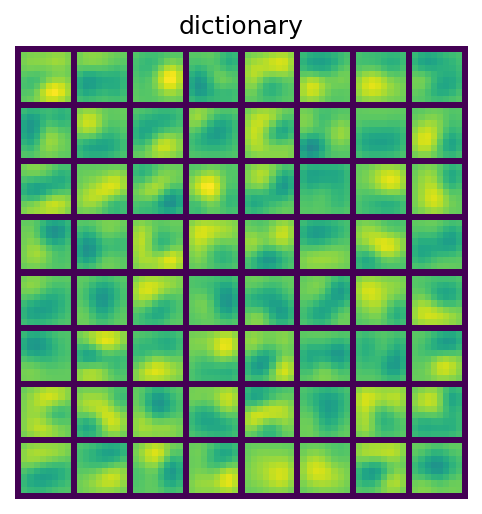

In [24]:
I_grid, Ihat_grid = utils.visualize_patches(I, Ihat)
phi_grid = utils.visualize_bases(phi_final)

utils.display(I_grid, "patches")
utils.display(Ihat_grid, "reconstruction")
utils.display(phi_grid, "dictionary", bar=False)